# Project 2
### Benjamin Tollison 428004920

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sympy as sp
from IPython.display import Latex, Math, display
from sympy import (
    Eq,
    Function,
    Matrix,
    cos,
    cosh,
    exp,
    integrate,
    lambdify,
    pi,
    sin,
    sinh,
    symbols,
)
from decimal import Decimal
from sympy.solvers.pde import pdsolve
from sympy.solvers.solveset import linsolve
def displayEquations(LHS,RHS):
    left = sp.latex(LHS)
    right = sp.latex(RHS)
    display(Math(left + '=' + right))
    np.set_printoptions(suppress=True)
def displayVariable(variable:str,RHS):
    left = sp.latex(symbols(variable))
    right = sp.latex(RHS)
    display(Math(left + '=' + right))
def displayVariableWithUnits(variable:str,RHS,units):
    left = sp.latex(symbols(variable))
    right = sp.latex(RHS)
    latexUnit = sp.latex(symbols(units))
    display(Math(left + '=' + right + '\\;' +'\\left['+ latexUnit + '\\right]'))
def format_scientific(number:float):
    a = '%E' % number
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]
deg2rad = np.pi/180
rad2deg = 180/np.pi

### Setting the Globals

In [2]:
UIN = 428004920
UIN = [int(x) for x in str(UIN)]
a,b,c = UIN[-3],UIN[-2],UIN[-1]
A = 3*a
B = 0.01*b
C = 100*c
gamma = 1.4
specific_heat_pressure = 1004.5 # J/kg-K
axial_flow_velocity = 160 + A # m/s
tip_diameter = 0.68 + B # m
hub_diameter = 0.46
angular_velocity = 8500 + C # rpm
rotor_turning_angle = 15*deg2rad
pressure_air = 101300 # Pa
temperature_air = 288 # K
universal_air_constant = 287 # J/kg-K
stator_turning_angle = 12*deg2rad

### Output the values of $r_{25\%},r_{50\%},r_{75\%}$ as a check

In [3]:
radius = np.linspace(hub_diameter/2,tip_diameter/2,100)
percent_radius = lambda percent: (percent/100)*(tip_diameter/2 - hub_diameter/2) + hub_diameter/2
example_radii = [percent_radius(25),percent_radius(50),percent_radius(75)]
def DisplayVelocityTrianglesValues(radius):
  displayVariableWithUnits('r',radius,'m')
  omega = angular_velocity*np.pi/30
  U = radius*omega
  V1 = axial_flow_velocity
  beta_1 = np.arctan(U/V1)
  displayVariableWithUnits('\\beta_1',beta_1*rad2deg,'deg')
  beta_15 = beta_1 - rotor_turning_angle
  displayVariableWithUnits('\\beta_{1.5}',beta_15*rad2deg,'deg')
  W_u15 = V1*np.tan(beta_15)
  displayVariableWithUnits('W_{u1.5}',W_u15,'\\frac{m}{s}')
  V_u15 = U - W_u15
  displayVariableWithUnits('V_{u1.5}',V_u15,'\\frac{m}{s}')
  alpha_15 = np.arctan(V_u15/V1)
  displayVariableWithUnits('\\alpha_{1.5}',alpha_15*rad2deg,'deg')
  alpha_2 = alpha_15 - stator_turning_angle
  displayVariableWithUnits('\\alpha_{2}',alpha_2*rad2deg,'deg')
  V2 = V1 / np.cos(alpha_2)
  displayVariableWithUnits('V_2',V2,'\\frac{m}{s}')
  return None
for r in example_radii:
  DisplayVelocityTrianglesValues(r)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Plotting the camber lines of the rotors and stators
For the rotor
- $ x = r\cos{\theta} $
- $ y = r\sin{\theta} $
- Start the list of values at the center of the camber at 90 degrees
- $ \pm 7.5 $ 
- apply a rotation about the z-axis of $T_3(\beta_1)$

The stator follows the same proccess except it is $\pm 6 $

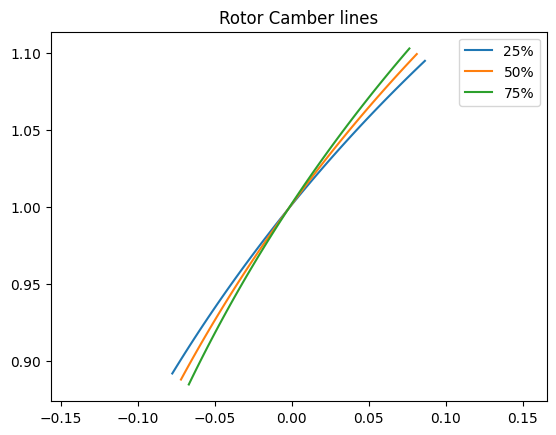

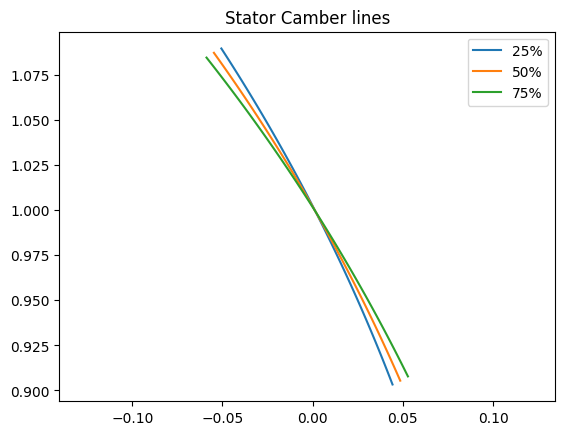

In [4]:
theta_rotor_values = np.linspace(np.pi/2 - 7.5*deg2rad, np.pi/2 + 7.5*deg2rad)
theta_stator_values = np.linspace(np.pi/2 - 6*deg2rad, np.pi/2 + 6*deg2rad)
x_rotor_values = [np.cos(theta) for theta in theta_rotor_values]
y_rotor_values = [np.sin(theta) for theta in theta_rotor_values]
x_stator_values = [np.cos(theta) for theta in theta_stator_values]
y_stator_values = [np.sin(theta) for theta in theta_stator_values]
theta_stator_values = np.linspace(np.pi/2 - 6*deg2rad, np.pi/2 + 6*deg2rad)
beta_25 = (51.0611855132678)*deg2rad
beta_50 = (54.0793233166643)*deg2rad
beta_75 = (56.7145349072857)*deg2rad
alpha_25 = (90+26.9952815702837)*deg2rad
alpha_50 = (90+29.610342617152)*deg2rad
alpha_75 = (90+32.2836233427272)*deg2rad
def RotationMatrix(beta):
    return np.array([[np.cos(beta), -np.sin(beta)],
                     [np.sin(beta), np.cos(beta)]])
def PlotRotorCamber(beta:float,label:str):
    rotation_matrix = RotationMatrix(beta)
    camber_points = np.array(list(zip(x_rotor_values, y_rotor_values)))
    camber_points_translated = camber_points - np.mean(camber_points, axis=0)
    camber_points_rotated = np.dot(rotation_matrix, camber_points_translated.T).T
    camber_points_rotated += np.mean(camber_points, axis=0)
    plt.plot(camber_points_rotated[:, 0], camber_points_rotated[:, 1],label=label)
    plt.axis('equal')
def PlotStatorCamber(beta:float,label:str):
    rotation_matrix = -RotationMatrix(beta)
    camber_points = np.array(list(zip(x_stator_values, y_stator_values)))
    camber_points_translated = camber_points - np.mean(camber_points, axis=0)
    camber_points_rotated = np.dot(rotation_matrix, camber_points_translated.T).T
    camber_points_rotated += np.mean(camber_points, axis=0)
    plt.plot(camber_points_rotated[:, 0], camber_points_rotated[:, 1],label=label)
    plt.axis('equal')
PlotRotorCamber(beta_25,'25%')
PlotRotorCamber(beta_50,'50%')
PlotRotorCamber(beta_75,'75%')
plt.title('Rotor Camber lines')
plt.legend()
plt.show()
PlotStatorCamber(alpha_25,'25%')
PlotStatorCamber(alpha_50,'50%')
PlotStatorCamber(alpha_75,'75%')
plt.title('Stator Camber lines')
plt.legend()
plt.show()

### Solving for power required
$$ \mathcal{P} = \dot{m}\left(U_1 V_{1u} - U_{1.5}V_{1.5u}\right) $$
- the projection of $V_1$ onto U is zero
- $U_{1.5} = f(r)$
- $V_{1.5u} = f(r)$

<IPython.core.display.Math object>

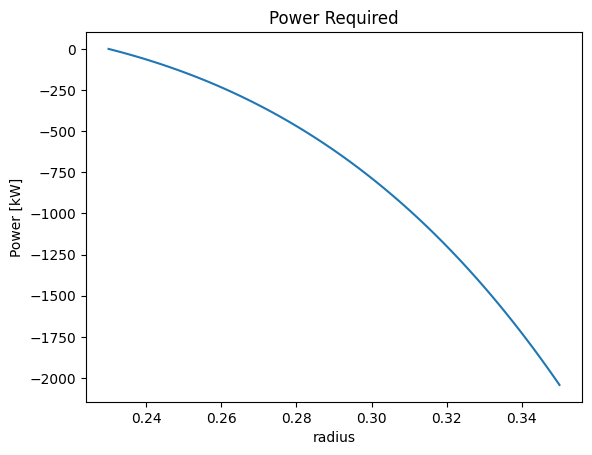

<IPython.core.display.Math object>

In [5]:
mass_flow_rate = lambda r: (pressure_air/(universal_air_constant*temperature_air))*np.pi*(r**2-(hub_diameter/2)**2)*axial_flow_velocity
U15 = lambda r: r*(angular_velocity*np.pi/30)
def V_u15(radius):
  omega = angular_velocity*np.pi/30
  U = radius*omega
  V1 = axial_flow_velocity
  beta_1 = np.arctan(U/V1)
  beta_15 = beta_1 - rotor_turning_angle
  W_u15 = V1*np.tan(beta_15)
  V_u15 = U - W_u15
  return V_u15
power_required = lambda radius: -mass_flow_rate(radius)*U15(radius)*V_u15(radius)
example_power = [(power_required(r))*10**-3 for r in example_radii]
displayVariableWithUnits('\\mathcal{P}_{75\\%}',min(example_power),'kW')
plt.plot(radius,power_required(radius)*10**-3)
plt.title('Power Required')
plt.xlabel('radius')
plt.ylabel('Power [kW]')
plt.show()
displayVariableWithUnits('\\mathcal{P}_{req}',min(power_required(radius))*10**-3,'kW')

### Variation of total enthalpy changes with the radius
$ h_{01} = c_p T_1 + \frac{V_1^2}{2}$ \
$ h_{02} = h_{01}+\lvert \frac{\mathcal{P}}{\dot{m}} \rvert = c_p T_2 + \frac{V_2^2}{2} $ and $ V_2 = \frac{V_1}{\cos(\alpha_{2})}$ \
Assuming the process is adiabatic then $h_{02} = c_p T_1 + \frac{V_2^2}{2} $

C:\Users\benja\AppData\Local\Temp\ipykernel_29032\1888662937.py:2: RuntimeWarning: invalid value encountered in scalar divide
  h_02 = lambda r: h_01 + abs(power_required(r)/mass_flow_rate(r))


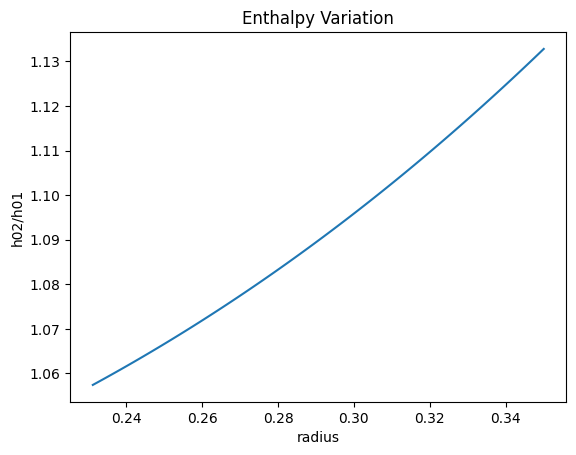

In [6]:
h_01 = specific_heat_pressure*temperature_air + axial_flow_velocity**2/2
h_02 = lambda r: h_01 + abs(power_required(r)/mass_flow_rate(r))
enthalpy_ratio_values = [h_02(r)/h_01 for r in radius]
plt.plot(radius,enthalpy_ratio_values)
plt.title('Enthalpy Variation')
plt.xlabel('radius')
plt.ylabel('h02/h01')
plt.show()

### Variation in the stagnation pressure ratio over the stage
using the general formula $ T_{01} = \frac{h_{01}}{c_p} $ and 
$$ \frac{p_{02}}{p_{01}} = \left(\frac{T_{02}}{T_{01}}\right)^\frac{\gamma}{\gamma-1} $$ 

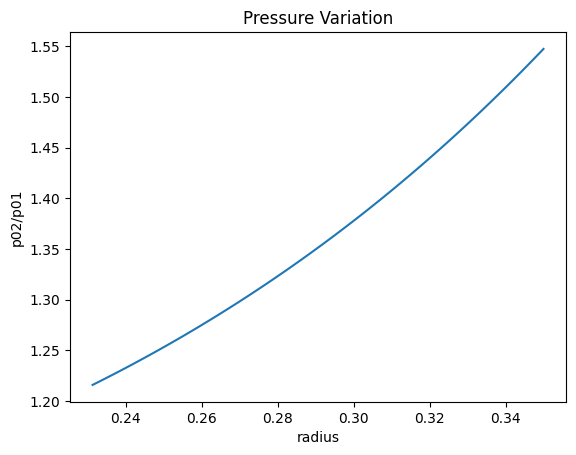

In [7]:
pressure_ratio_values = [h**(1.4/.4) for h in enthalpy_ratio_values]
plt.plot(radius,pressure_ratio_values)
plt.title('Pressure Variation')
plt.xlabel('radius')
plt.ylabel('p02/p01')
plt.show()

### Degree of Reaction

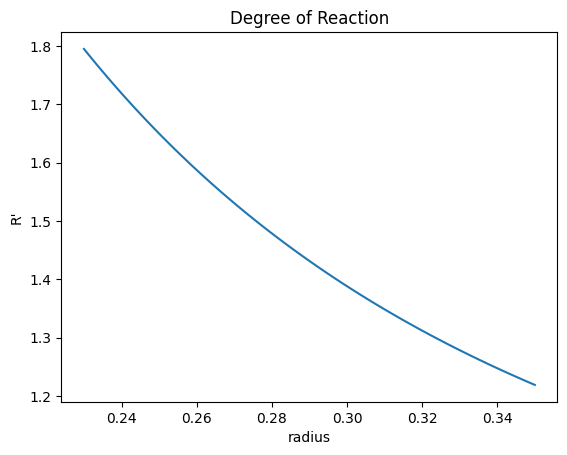

In [8]:
def DegreeOfReaction(radius):
  omega = angular_velocity*np.pi/30
  U = radius*omega
  V1 = axial_flow_velocity
  W1 = np.sqrt(U**2+V1**2)
  beta_1 = np.arctan(U/V1)
  beta_15 = beta_1 - rotor_turning_angle
  W_u15 = V1*np.tan(beta_15)
  V_u15 = U - W_u15
  return (W1**2-W_u15**2)/(2*U*V_u15)
plt.plot(radius,DegreeOfReaction(radius))
plt.title('Degree of Reaction')
plt.xlabel('radius')
plt.ylabel("R'")
plt.show()

### de Haller Number

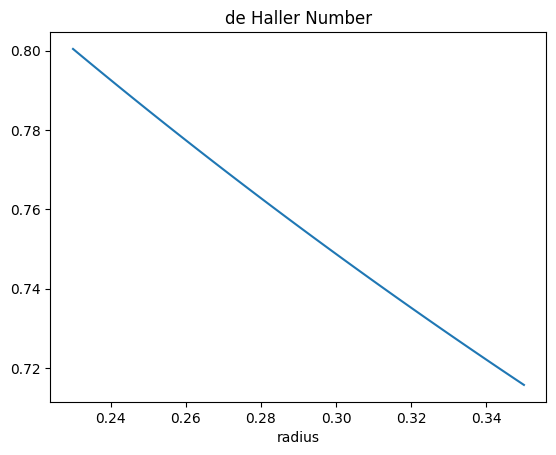

In [9]:
def deHallerNumber(radius):
  omega = angular_velocity*np.pi/30
  U = radius*omega
  V1 = axial_flow_velocity
  W1 = np.sqrt(U**2+V1**2)
  beta_1 = np.arctan(U/V1)
  beta_15 = beta_1 - rotor_turning_angle
  W15 = V1/np.cos(beta_15)
  return W15/W1
plt.plot(radius,deHallerNumber(radius))
plt.title('de Haller Number')
plt.xlabel('radius')
plt.show()

### Flow Coefficient
$$ \phi = \frac{V_{abs}}{U(r)} $$

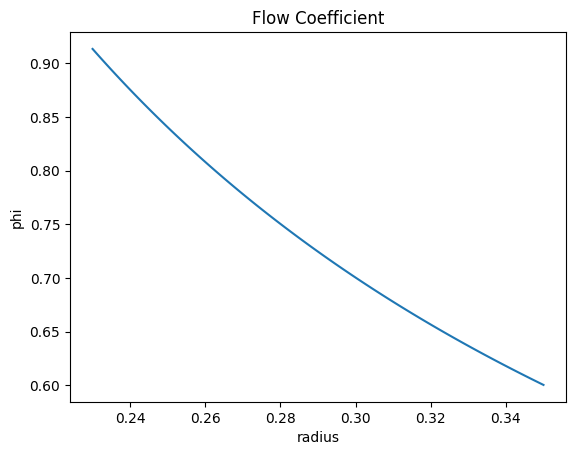

In [10]:
def FlowCoefficient(radius):
  omega = angular_velocity*np.pi/30
  U = radius*omega
  return axial_flow_velocity / U
plt.plot(radius,FlowCoefficient(radius))
plt.title('Flow Coefficient')
plt.xlabel('radius')
plt.ylabel('phi')
plt.show()

### Work Coefficient

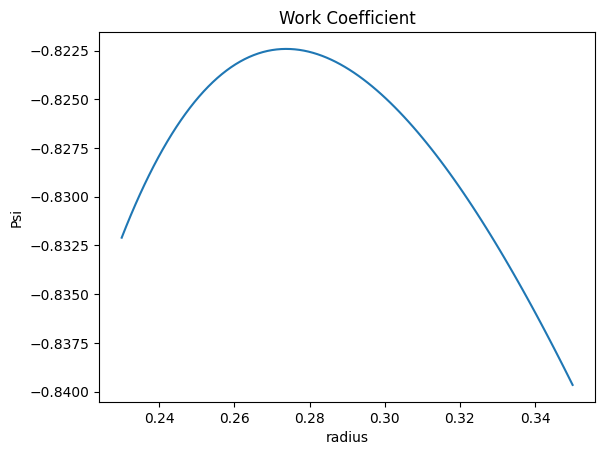

In [11]:
def WorkCoefficient(radius):
  omega = angular_velocity*np.pi/30
  U = radius*omega
  V1 = axial_flow_velocity
  beta_1 = np.arctan(U/V1)
  beta_15 = beta_1 - rotor_turning_angle
  W_u15 = V1*np.tan(beta_15)
  V_u15 = U - W_u15
  return (-2*V_u15)/U
plt.plot(radius,WorkCoefficient(radius))
plt.title('Work Coefficient')
plt.xlabel('radius')
plt.ylabel('Psi')
plt.show()

### Mach Number
Assuming adaibatic flow througout the inlet of the compressor
$$ M = \frac{W_1}{\sqrt{\gamma R T_1}} $$

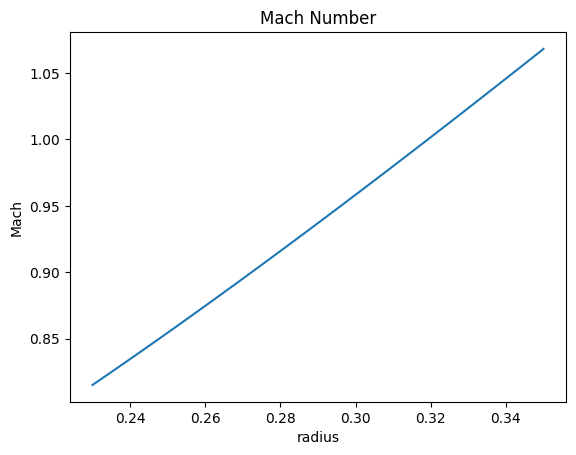

In [12]:
def Mach(radius):
  omega = angular_velocity*np.pi/30
  U = radius*omega
  V1 = axial_flow_velocity
  W1 = np.sqrt(U**2+V1**2)
  speed_of_sound = np.sqrt(1.4*287*temperature_air)
  return W1/speed_of_sound
plt.plot(radius,Mach(radius))
plt.title('Mach Number')
plt.xlabel('radius')
plt.ylabel('Mach')
plt.show()